In [1]:
import random
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
from IPython import display
from memory import Memory
from utils import preprocess
from model.simple_stack import SimpleStack

/home/seventheli/anaconda3/lib/python3.8/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.10.1+cu113` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


### Summary of the algorithm
#### Update Network
* Draw batches of tuples from the replay buffer: $(\phi,r,a,\phi')$.
* Define the following loss
$$\Large(\small Q(\phi,a,\theta)-r-Q(\phi',argmax_{a'}Q(\phi',a',\theta),\theta^-)\Large)^2$$
* Where $\theta^-$ is the parameter of the target network.( Set $Q(\phi',a',\theta^-)$ to zero if $\phi$ is the preprocessed termination state). 
* Update the $\theta$
* Update the $\theta^-$ once in a while








## Set the hyper-parameters

In [2]:
# frame channel
channel = 1
# The size of the batch to learn the Q-function
batch_size = 16
# Resize the raw input frame to square frame of size 80 by 80
image_size = 84
# Skip 4-1 raw frames between steps
skip_frame = 4
# Skip 4-1 raw frames between skipped frames
internal_skip_frame = 4
# The size of replay buffer; set it to size of your memory (.5M for 50G available memory)
replay_buffer_size = 100000
# With Freq of 1/4-step update the Q-network
learning_frequency = 4
# Each state is formed as a concatenation 4 step frames [f(t-12),f(t-8),f(t-4),f(t)]
frame_len = 4
# Update the target network each 10000 steps
target_update = 10000
# Minimum level of stochasticity of policy (epsilon)-greedy
epsilon_min = 0.01
# The number of step it take to linearly anneal the epsilon to it min value
annealing_end = 1000000.
# The discount factor
gamma = 0.99
# Start to back propagated through the network, learning starts
replay_start_size = 50000
# Run uniform policy for first 30 times step of the beginning of the game
no_op_max = 8
# Number episode to run the algorithm
num_episode = 10000000
max_frame = 200000000
# RMSprop learning rate
lr = 0.00025
# RMSprop gamma1
gamma1 = 0.95
# RMSprop gamma2
gamma2 = 0.95
# RMSprop epsilon bias
rms_eps = 0.01
# Enables gpu if available, if not, set it to mx.cpu()
ctx = mx.gpu()

In [3]:
env_name = 'AssaultNoFrameskip-v4'
env = gym.make(env_name)
num_action = env.action_space.n
manualSeed = 1
mx.random.seed(manualSeed)

In [4]:
dqn = SimpleStack(env.action_space.n, frame_len, channel=channel)
dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)
trainer = gluon.Trainer(dqn.collect_params(), 'RMSProp',
                        {'learning_rate': lr, 'gamma1': gamma1, 'gamma2': gamma2, 'epsilon': rms_eps, 'centered': True})
dqn.collect_params().zero_grad()

In [5]:
target_dqn = SimpleStack(env.action_space.n, frame_len, channel=channel)
target_dqn.collect_params().initialize(mx.init.Normal(0.02), ctx=ctx)

In [6]:
def rew_clipper(rew_clip):
    if rew_clip > 0.:
        return 1.
    elif rew_clip < 0.:
        return -1.
    else:
        return 0


def render_image(frame, render):
    if render:
        plt.imshow(frame)
        plt.show()
        display.clear_output(wait=True)
        time.sleep(.1)

In [7]:
loss_f = mx.gluon.loss.L2Loss(batch_axis=0)
# Counts the number of steps so far
frame_counter = 0.
# Counts the number of annealing steps
annealing_count = 0.
# Counts the number episodes so far
epis_count = 0.
# Initialize the replay buffer
replay_memory = Memory(replay_buffer_size)
tot_clipped_reward = []
tot_reward = []
frame_count_record = []
moving_average_clipped = 0.
moving_average = 0.

### Train the model

In [8]:
# Whether to render Frames and show the game
_render = False
while epis_count < max_frame:
    cum_clipped_reward = 0
    cum_reward = 0
    next_frame = env.reset()
    state, current_frame = preprocess(next_frame, image_size, channel, frame_len, initial_state=True)
    t = 0.
    done = False
    initial_state = True
    while not done:
        previous_state = state
        # show the frame
        render_image(next_frame, _render)
        sample = random.random()
        if frame_counter > replay_start_size:
            annealing_count += 1
        if frame_counter == replay_start_size:
            print('annealing and learning are started ')
        eps = np.maximum(1. - annealing_count / annealing_end, epsilon_min)

        effective_eps = eps
        if t < no_op_max:
            effective_eps = 1.
        # epsilon greedy policy
        if sample < effective_eps:
            action = random.randint(0, num_action - 1)
        else:
            data = [nd.array(state.reshape([1, frame_len * channel, image_size, image_size]), ctx), nd.array([100], ctx)]
            action = int(nd.argmax(dqn(*data), axis=1).as_in_context(mx.cpu()).asscalar())
            
        
        # Skip frame
        rew = 0
        for skip in range(skip_frame - 1):
            next_frame, reward, done, _ = env.step(action)
            render_image(next_frame, _render)
            cum_clipped_reward += rew_clipper(reward)
            rew += reward
            for internal_skip in range(internal_skip_frame - 1):
                _, reward, done, _ = env.step(action)
                cum_clipped_reward += rew_clipper(reward)
                rew += reward

        next_frame_new, reward, done, _ = env.step(action)
        render_image(next_frame, _render)
        cum_clipped_reward += rew_clipper(reward)
        rew += reward
        cum_reward += rew

        # Reward clipping

        reward = rew_clipper(rew)
        next_frame = np.maximum(next_frame_new, next_frame)
        
        
        state, current_frame = preprocess(next_frame, image_size, channel, frame_len, current_state=state)
        replay_memory.push(previous_state, action, state, reward, done, 100)

        # Train
        if frame_counter > replay_start_size and frame_counter % learning_frequency == 0:
            batch = replay_memory.sample(batch_size, ctx)
            batch_state = batch.state
            batch_state_next = batch.state_next
            batch_battery  = batch.battery
            batch_reward = batch.reward
            batch_action = batch.action.astype('uint8')
            batch_done = batch.finish
            with autograd.record():
                argmax_Q = nd.argmax(dqn(batch_state_next, batch_battery),axis = 1).astype('uint8')
                Q_sp = nd.pick(target_dqn(batch.state_next, batch.battery),argmax_Q,1)
                Q_sp = Q_sp*(nd.ones(batch_size,ctx = ctx)-batch_done)
                Q_s_array = dqn(batch_state, batch_battery)
                Q_s = nd.pick(Q_s_array,batch_action,1)
                loss = nd.mean(loss_f(Q_s ,  (batch_reward + gamma *Q_sp)))
            loss.backward()
            trainer.step(batch_size)
        t += 1
        frame_counter += 1
        # Save the model and update Target model
        if frame_counter >replay_start_size and frame_counter % target_update == 0:
            check_point = frame_counter / (target_update * 100)
            file_name = './data/target_%s_%d' % (env_name, int(check_point))
            dqn.save_parameters(file_name)
            target_dqn.load_parameters(file_name, ctx)
        if done:
            if epis_count % 50. == 0. :
                print('epis[%d],eps[%.4f],durat[%d],fnum=%d, cum_cl_rew = %d, cum_rew = %.4f,tot_cl = %.4f , tot = %.4f'\
                  %(epis_count,eps,t+1,frame_counter,cum_clipped_reward,cum_reward,moving_average_clipped,moving_average))
    epis_count += 1
    tot_clipped_reward = np.append(tot_clipped_reward, cum_clipped_reward)
    tot_reward = np.append(tot_reward, cum_reward)
    frame_count_record = np.append(frame_count_record,frame_counter)
    if epis_count > 100.:
        moving_average_clipped = np.mean(tot_clipped_reward[int(epis_count)-1-100:int(epis_count)-1])
        moving_average = np.mean(tot_reward[int(epis_count)-1-100:int(epis_count)-1])

epis[0],eps[1.0000],durat[218],fnum=217, cum_cl_rew = 9, cum_rew = 189.0000,tot_cl = 0.0000 , tot = 0.0000
epis[50],eps[1.0000],durat[351],fnum=13313, cum_cl_rew = 9, cum_rew = 189.0000,tot_cl = 0.0000 , tot = 0.0000
epis[100],eps[1.0000],durat[299],fnum=26251, cum_cl_rew = 10, cum_rew = 210.0000,tot_cl = 0.0000 , tot = 0.0000
epis[150],eps[1.0000],durat[264],fnum=38414, cum_cl_rew = 10, cum_rew = 210.0000,tot_cl = 8.9200 , tot = 187.3200
annealing and learning are started 
epis[200],eps[0.9986],durat[258],fnum=51399, cum_cl_rew = 9, cum_rew = 189.0000,tot_cl = 8.9700 , tot = 188.3700
epis[250],eps[0.9854],durat[386],fnum=64586, cum_cl_rew = 10, cum_rew = 210.0000,tot_cl = 8.9400 , tot = 187.7400
epis[300],eps[0.9719],durat[242],fnum=78126, cum_cl_rew = 8, cum_rew = 168.0000,tot_cl = 9.2300 , tot = 193.8300
epis[350],eps[0.9583],durat[282],fnum=91692, cum_cl_rew = 5, cum_rew = 105.0000,tot_cl = 9.4600 , tot = 198.6600
epis[400],eps[0.9454],durat[90],fnum=104649, cum_cl_rew = 4, cum_rew

epis[3550],eps[0.1150],durat[348],fnum=934956, cum_cl_rew = 38, cum_rew = 787.0000,tot_cl = 33.1400 , tot = 684.6100
epis[3600],eps[0.0997],durat[274],fnum=950273, cum_cl_rew = 37, cum_rew = 755.0000,tot_cl = 33.3500 , tot = 688.6900
epis[3650],eps[0.0846],durat[239],fnum=965417, cum_cl_rew = 24, cum_rew = 504.0000,tot_cl = 33.5500 , tot = 685.3000
epis[3700],eps[0.0700],durat[268],fnum=980007, cum_cl_rew = 26, cum_rew = 546.0000,tot_cl = 32.0100 , tot = 652.7400
epis[3750],eps[0.0528],durat[348],fnum=997215, cum_cl_rew = 40, cum_rew = 796.0000,tot_cl = 34.0600 , tot = 694.6900
epis[3800],eps[0.0342],durat[545],fnum=1015763, cum_cl_rew = 63, cum_rew = 1312.0000,tot_cl = 39.8100 , tot = 803.3400
epis[3850],eps[0.0162],durat[357],fnum=1033825, cum_cl_rew = 46, cum_rew = 867.0000,tot_cl = 42.1100 , tot = 849.2200
epis[3900],eps[0.0100],durat[252],fnum=1051368, cum_cl_rew = 33, cum_rew = 693.0000,tot_cl = 42.9800 , tot = 869.0300
epis[3950],eps[0.0100],durat[245],fnum=1067588, cum_cl_rew =

KeyboardInterrupt: 

### Plot the overall performace

Running after 5154 number of episodes


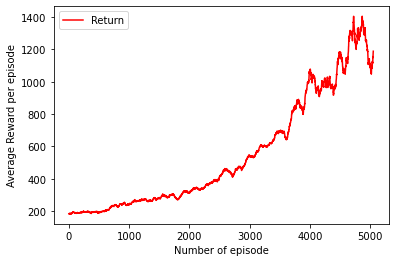

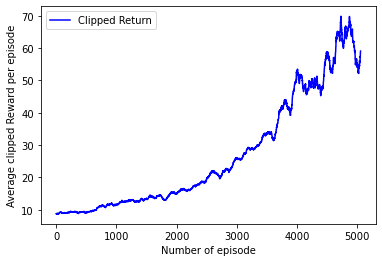

In [9]:
num_epis_count = epis_count - 0
bandwidth = 100  # Moving average bandwidth
total_clipped = np.zeros(int(num_epis_count) - bandwidth)
total_rew = np.zeros(int(num_epis_count) - bandwidth)
for i in range(int(num_epis_count) - bandwidth):
    total_clipped[i] = np.sum(tot_clipped_reward[i:i + bandwidth]) / bandwidth
    total_rew[i] = np.sum(tot_reward[i:i + bandwidth]) / bandwidth
t = np.arange(int(num_epis_count) - bandwidth)
fig = plt.figure()
belplt = plt.plot(t, total_rew[0:int(num_epis_count) - bandwidth], "r", label="Return")
plt.legend()  #handles[likplt,belplt])
print('Running after %d number of episodes' % epis_count)
plt.xlabel("Number of episode")
plt.ylabel("Average Reward per episode")
plt.show()
fig.savefig('Assualt_DDQN.png')
fig = plt.figure()
likplt = plt.plot(t, total_clipped[0:num_episode - bandwidth], "b", label="Clipped Return")
plt.legend()  #handles[likplt,belplt])
plt.xlabel("Number of episode")
plt.ylabel("Average clipped Reward per episode")
plt.show()
fig.savefig('DDQN_Clipped.png')